DISCLAIMER: Check "model/" folder for the complete code!

# Prerequisites

In [11]:
import sys, os

import torch
import numpy as np

Important paths for the notebook:

In [12]:
test_number = 3

homework_root_path = '../../'
data_root_path = '../../data/'

data_train_path = os.path.join( data_root_path , 'train.tsv' )
data_dev_path = os.path.join( data_root_path , 'dev.tsv' )

models_classes_path = '../../model/test' + str(test_number) + '/'
models_saves_path = '../../model/test' + str(test_number) + '/saves/'

In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

Setting the seed for reproducibility:

In [14]:
SEED = 28

# random.seed(SEED) # not used
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

Path:

In [15]:
sys.path.append( models_classes_path )

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Global parameters

These parameters are needed in various classes, so they will be saved so to be used in the final model:

In [16]:
globalParams = {
    'PAD_TOKEN': '<pad>',
    'PAD_INDEX': -1,
    'UNK_TOKEN': '<unk>',
    'window_size': 41,
    'window_shift': 41 - 20
}

# Using GloVe as embedding

After the first test done with "test1" and by seeing the results done in "test2", I sticked with GloVe word vector representation. <br>
The padding and the unknown tokens were added at the extracted embedding layer and also at the vocabulary mappings.

In [17]:
import gensim.downloader as gensim_api

embedding_keyedvectors = gensim_api.load('glove-wiki-gigaword-300')

/home/marco/miniconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


Observing the space:

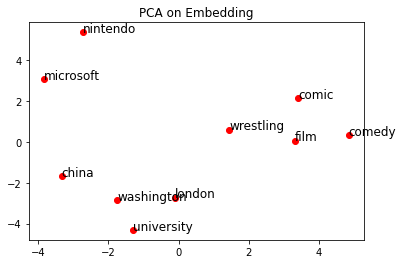

In [18]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def plot_some_data():
    # pick some words to visualise
    words = ['film','washington','comedy','university','wrestling','london','china','microsoft','comic','nintendo']
    
    # retrieve the trained embeddings
    coords = [embedding_keyedvectors[word] for word in words]
    

    # perform PCA to reduce our Nd embeddings to 2d points that can be plotted
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(coords) # .t() transpose the embeddings
    
    for i,(x,y) in enumerate(pca_result):
        plt.plot(x, y, 'ro')
        plt.text(x, y, words[i], fontsize=12) # add a point label, shifted wrt to the point
    plt.title('PCA on Embedding')
    plt.show()
    
plot_some_data()

In [19]:
def create_embedding_from_keyedvectors(keyedvectors, freeze = False):
    vectors = keyedvectors.vectors
    padding_idx = vectors.shape[0]
    # pad vector is all zeros
    pad = np.zeros((1, vectors.shape[1]))
    # unk vector is the mean vector
    unk = np.mean(vectors, axis=0, keepdims=True)
    # concatenate
    weights = torch.FloatTensor( np.concatenate((vectors,pad,unk)) )
    return torch.nn.Embedding.from_pretrained(weights, padding_idx=padding_idx, freeze=freeze)

In [20]:
embedding_layer = create_embedding_from_keyedvectors(embedding_keyedvectors, freeze = True)

In [21]:
embedding_layer.num_embeddings, embedding_layer.embedding_dim

(400002, 300)

In [22]:
def create_vocabulary_from_keyedvectors(keyedvectors, globalParams):
    index_to_key = keyedvectors.index_to_key.copy()
    key_to_index = keyedvectors.key_to_index.copy()
    
    index_to_key.append(globalParams['PAD_TOKEN'])
    index_to_key.append(globalParams['UNK_TOKEN'])

    key_to_index[globalParams['PAD_TOKEN']] = len(key_to_index)
    key_to_index[globalParams['UNK_TOKEN']] = len(key_to_index)

    return {'key_to_index':key_to_index, 'index_to_key':index_to_key}

In [23]:
vocabulary = create_vocabulary_from_keyedvectors(embedding_keyedvectors, globalParams)

In [24]:
vocabulary['index_to_key'][-2], vocabulary['index_to_key'][-1]

('<pad>', '<unk>')

In [25]:
vocabulary['key_to_index'][globalParams['PAD_TOKEN']], vocabulary['key_to_index'][globalParams['UNK_TOKEN']]

(400000, 400001)

# Dataset

The dataset is still the same as in the second test

In [26]:
from NERDataset import NERDataset

In [27]:
dataset_train = NERDataset(data_train_path, vocabulary = vocabulary, params = globalParams)
dataset_dev = NERDataset(data_dev_path, vocabulary = None, params = globalParams)

Checking how many OOVs are in the training

In [28]:
words_in_train = list(set(word for sample in dataset_train for word in sample['inputs']))
words_not_present = [w for w in words_in_train if w not in vocabulary['key_to_index']]
print( len( words_not_present ) , 'words not present out of' , len(words_in_train))

3399 words not present out of 29966


Saving everything for later

In [29]:
dataset_train.save_labels( os.path.join(models_saves_path,'dataset_labels.npy') )

/home/marco/miniconda3/envs/nlp2022-hw1/lib/python3.9/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [30]:
dataset_train.save_vocabulary( os.path.join(models_saves_path,'dataset_vocabulary.npy') )

Creating the Dataloader:

In [31]:
BATCH_SIZE = 32
EPOCHS = 200

In [32]:
prepare_batch = NERDataset.prepare_batch_fn(dataset_train.vocabulary, dataset_train.label2id, globalParams['UNK_TOKEN'])

In [33]:
from torch.utils.data import DataLoader

dataloader_train = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True, collate_fn=prepare_batch)
dataloader_dev = DataLoader(dataset_dev, batch_size=BATCH_SIZE, shuffle=False, collate_fn=prepare_batch)

In [34]:
for x in dataloader_dev:
    generic_element = x
    break
np.array(generic_element['inputs']).shape # (batch_size, window_size)

(32, 41)

In [35]:
print('Input')
print(generic_element['inputs'][0])
print('Output')
print(generic_element['outputs'][0])

Input
tensor([    13,      0,    122,      3,      0,   3160,    785,   9414,   4606,
           145,   3385, 400001,     69,     38,     40,   1315,   2141,      2,
        400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000,
        400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000, 400000,
        400000, 400000, 400000, 400000, 400000])
Output
tensor([12, 12, 12, 12, 12, 12,  4, 10, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1])


In [36]:
input_size = len(vocabulary['key_to_index']) # how many different words?
input_length_train = max([len(sentence_list['inputs']) for sentence_list in dataset_train]) # maximum length of sentence
input_length_dev = max([len(sentence_list['inputs']) for sentence_list in dataset_dev]) # maximum length of sentence (dev)
n_labels = len(dataset_train.label2id)

print('input_size: ', input_size, '\nmax input_length train: ', input_length_train, '\nmax input_length dev: ', input_length_dev, '\nn_labels: ', n_labels)

input_size:  400002 
max input_length train:  41 
max input_length dev:  41 
n_labels:  13


# The Model

The model here is changed: the CRF layer is added! In addition, the model is generalized in order to do hyper-parameter tuning

The loss function if CRF is not used:

In [37]:
loss_function = torch.nn.CrossEntropyLoss(ignore_index=globalParams['PAD_INDEX']) # !

These are all the parameters needed to initialize the model:

In [41]:
globalParams['embedding_shape'] = ( embedding_layer.num_embeddings , embedding_layer.embedding_dim )
globalParams['n_labels'] = n_labels
globalParams['seq_encoder_parameters'] = [
    {'hidden_size':80,'bidirectional':True, 'num_layers':2, 'dropout':0.2},
]
globalParams['use_crf'] = False

Saving global variables...

In [42]:
np.save(os.path.join(models_saves_path, 'global_params.npy'), globalParams)

In [43]:
globalParams = np.load(os.path.join(models_saves_path, 'global_params.npy'), allow_pickle=True).tolist()
globalParams

{'PAD_TOKEN': '<pad>',
 'PAD_INDEX': -1,
 'UNK_TOKEN': '<unk>',
 'window_size': 41,
 'window_shift': 21,
 'embedding_shape': (400002, 300),
 'n_labels': 13,
 'seq_encoder_parameters': [{'hidden_size': 80,
   'bidirectional': True,
   'num_layers': 2,
   'dropout': 0.2}],
 'use_crf': False}

# Putting everything together

In [192]:
from FinalModel import FinalModel

In [193]:
if 'embedding_layer' not in locals() or embedding_layer is None:
    print('|WARN| embedding_layer NOT INITIALIZED')
    embedding_layer = None

if 'loss_function' not in locals() or loss_function is None:
    print('|WARN| loss_function NOT INITIALIZED')
    loss_function = None

In [194]:
# cross-entropy will not be used if there's the crf layer
student = FinalModel(
    models_saves_path, 
    model_save_file_name = 'nernet_weights_nocrf.pth',
    load_model = True, 
    custom_embedding_layer = embedding_layer, 
    loss_fn = loss_function
)

Creating final model...
Creating model...
Loading model weights...
Loading model weights failed with strict=True, trying with False...
Init done


Hardcoding transition matrix, fixing gradient...


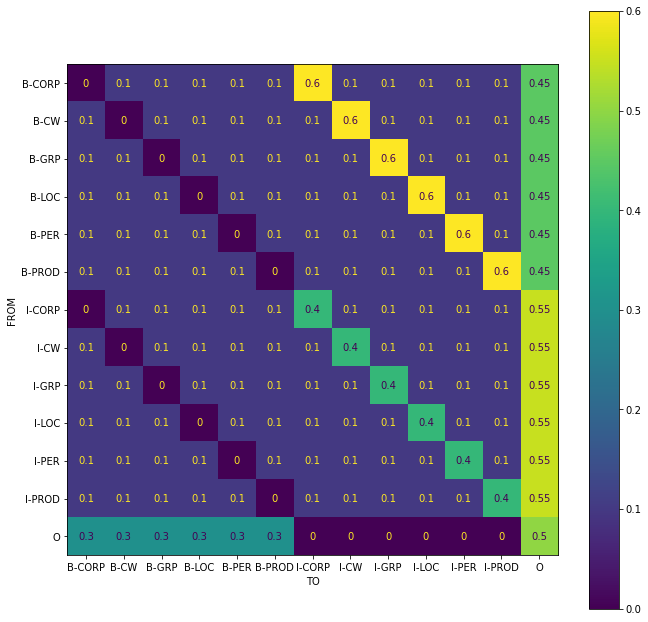

In [213]:
from sklearn.metrics import ConfusionMatrixDisplay

debug_freeze = False
debug_transition = True

if debug_freeze:
    print('Freezing all layers except CRF...')
    # freezing until the layer of CRF !
    for param in student.model.embedding.parameters():
        param.requires_grad = False
    for lstm in student.model.seq_encoder:
        for param in lstm.parameters():
            param.requires_grad = False
    for param in student.model.classifier.parameters():
        param.requires_grad = False

    EPOCHS = 30 # setting new epochs limit

if debug_transition:
    print('Hardcoding transition matrix, fixing gradient...')
    # setting matrix
    t_mat = torch.full(student.model.crf.trans_matrix.shape,0.1,device=device)
    for i in range(0,6): # B -> I same class
        t_mat[i,i+6] = 0.6
    for i in range(0,6): # I -> I same class
        t_mat[i+6,i+6] = 0.4
    for i in range(0,6): # O -> any B
        t_mat[12,i] = 0.3
    for i in range(0,6): # O -> any I
        t_mat[12,i+6] = 0
    for i in range(0,6): # B -> O
        t_mat[i,12] = 0.45
    for i in range(0,6): # I -> O
        t_mat[i+6,12] = 0.55
    for i in range(0,6): # B-X -> B-X or B-Y
        for j in range(0,6):
            if i == j: # B-X -> B-X
                t_mat[i,j] = 0
    for i in range(0,6): # I-X -> B-X or B-Y
        for j in range(0,6):
            if i == j: # I-X -> B-X
                t_mat[i+6,j] = 0
    t_mat[12,12] = 0.5 # O -> O
    
    student.model.crf.trans_matrix = torch.nn.parameter.Parameter( t_mat , requires_grad=False )

    mtrx = student.model.crf.trans_matrix.cpu().detach().numpy()
    cmdx = ConfusionMatrixDisplay(mtrx, display_labels=dataset_train.id2label)
    figx, axx = plt.subplots(figsize=(11,11))
    cmdx.plot(ax=axx)
    cmdx.ax_.set_xlabel('TO')
    cmdx.ax_.set_ylabel('FROM')

Unfortunately, torch.summary or torchinfo doesn't work with some implementations of CRF, so a fallback was necessary

In [140]:
from torchinfo import summary

print_summary_extended = False

def print_summary(model):
    print(model)
    print('----------------------')
    p = sum(p.numel() for p in model.parameters())
    tp = sum(p.numel() for p in model.parameters() if p.requires_grad)
    ntp = p - tp
    print('parameters:', f'{p:,}')
    print('trainable parameters:', f'{tp:,}')
    print('non-trainable parameters:', f'{ntp:,}')


if print_summary_extended:
    summary(student.model, 
            input_data=generic_element['inputs'], 
            col_names=["kernel_size", "output_size", "num_params"])
else:
    print_summary(student.model)
    

NERNet(
  (embedding): Embedding(400002, 300, padding_idx=400000)
  (seq_encoder): ModuleList(
    (0): LSTM(300, 80, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  )
  (classifier): Linear(in_features=160, out_features=13, bias=True)
  (crf): CRF()
)
----------------------
parameters: 120,402,248
trainable parameters: 401,479
non-trainable parameters: 120,000,769


# Training Phase

This training function was taken and modified from the notebook #5:

In [125]:
from seqeval.metrics import accuracy_score, f1_score

def train_and_evaluate(
    final_model,
    optimizer: torch.optim.Optimizer,
    train_dataloader: DataLoader,
    valid_dataloader: DataLoader = None,
    valid_data_input = None,
    valid_data_output = None,
    epochs: int = 5,
    verbose: bool = True,
    device = 'cpu'
):

    train_history = []
    valid_loss_history = []
    valid_f1_history = []

    final_model.model.to(device)

    for epoch in range(epochs):
        losses = []
        
        final_model.model.train()

        # batches of the training set
        for step, sample in enumerate(train_dataloader):
            inputs = sample['inputs'].to(device)
            labels = sample['outputs']
            
            optimizer.zero_grad()
            
            predictions = final_model.model.compute_outputs(inputs)

            if final_model.model.crf is not None:
                predictions = torch.tensor(predictions)
            else:
                predictions = predictions.view(-1, predictions.shape[-1]) # (batch , sentence , n_labels) -> (batch*sentence , n_labels)
                labels = labels.view(-1) # (batch , sentence) -> (batch*sentence)

            predictions = predictions.to(device)
            labels = labels.to(device)
            sample_loss = final_model.model.compute_loss( predictions, labels, ~labels.eq(-1) )

            sample_loss.backward()
            optimizer.step()

            losses.append(sample_loss.item())
            

        mean_loss = sum(losses) / len(losses)
        train_history.append(mean_loss)
        
        if verbose or epoch == epochs - 1:
            print(f'  Epoch {epoch:3d} => avg_loss: {mean_loss:0.6f}')
        
        if valid_data_output is not None and valid_dataloader is not None:
            f1_s = evaluate_f1(final_model, valid_data_input, valid_data_output, device)
            valid_loss = evaluate_loss(final_model, valid_dataloader, device)
            valid_loss_history.append(valid_loss)
            valid_f1_history.append(f1_s)
            if verbose:
                print(f'    Validation loss => {valid_loss:0.6f} f1-score => {f1_s:0.6f}')
                print()
                
        
    return {'train_history':train_history, 'valid_loss_history':valid_loss_history, 'valid_f1_history':valid_f1_history}

def evaluate_f1(final_model, valid_data_input, valid_data_label, device):
    final_model.model.eval()
    final_model.model.to(device)
    with torch.no_grad():
        data_eval_predict = final_model.predict(valid_data_input)
    f1_s = f1_score(valid_data_label, data_eval_predict, average="macro")
    return f1_s

def evaluate_loss(final_model, valid_dataset, device):
    valid_loss = 0.0
    final_model.model.eval()
    final_model.model.to(device)
    with torch.no_grad():
        for sample in valid_dataset:
            inputs = sample['inputs'].to(device)
            labels = sample['outputs']

            predictions = final_model.model.compute_outputs(inputs)
            
            if final_model.model.crf is not None:
                predictions = torch.tensor(predictions)
            else:
                predictions = predictions.view(-1, predictions.shape[-1]).to(device) # (batch , sentence , n_labels) -> (batch*sentence , n_labels)
                labels = labels.view(-1) # (batch , sentence) -> (batch*sentence)

            predictions = predictions.to(device)
            labels = labels.to(device)

            sample_loss = final_model.model.compute_loss( predictions, labels, ~labels.eq(-1) )
            valid_loss += sample_loss.tolist()

    return valid_loss / len(valid_dataset)

In [126]:
import torch.optim as optim

train_model = True

if train_model:

    optimizer = optim.SGD(student.model.parameters(), lr=0.0016, momentum=0.9)
    # optimizer = optim.Adam(student.model.parameters(), lr=0.0016)

    data_eval_input = []
    data_eval_label = []
    for sentence in NERDataset.read_dataset(data_dev_path):
        data_eval_input.append(sentence['inputs'])
        data_eval_label.append(sentence['outputs'])

    history = train_and_evaluate(   student, optimizer, dataloader_train, dataloader_dev,
                                    data_eval_input, data_eval_label, epochs=EPOCHS, verbose=True, device=device)

/tmp/ipykernel_729/1022068399.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(predictions)


  Epoch   0 => avg_loss: 2.012379


/tmp/ipykernel_729/1022068399.py:89: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(predictions)


    Validation loss => 3.500026 f1-score => 0.612587

  Epoch   1 => avg_loss: 1.889090
    Validation loss => 3.410215 f1-score => 0.623136

  Epoch   2 => avg_loss: 1.825148
    Validation loss => 3.351537 f1-score => 0.623580

  Epoch   3 => avg_loss: 1.776440
    Validation loss => 3.310906 f1-score => 0.626542

  Epoch   4 => avg_loss: 1.736827
    Validation loss => 3.280653 f1-score => 0.625562

  Epoch   5 => avg_loss: 1.717327
    Validation loss => 3.257633 f1-score => 0.624883

  Epoch   6 => avg_loss: 1.691870
    Validation loss => 3.239586 f1-score => 0.628049

  Epoch   7 => avg_loss: 1.678347
    Validation loss => 3.224196 f1-score => 0.626260

  Epoch   8 => avg_loss: 1.654008
    Validation loss => 3.211360 f1-score => 0.625304

  Epoch   9 => avg_loss: 1.670354
    Validation loss => 3.200704 f1-score => 0.625497

  Epoch  10 => avg_loss: 1.638448
    Validation loss => 3.191675 f1-score => 0.628035

  Epoch  11 => avg_loss: 1.624987
    Validation loss => 3.183878 

# Saving...

In [59]:
save_model = True

if save_model:
    student.model.save_weights(os.path.join(models_saves_path,'nernet_weights_crf2.pth'))

Displaying the transition matrix in the CRF layer

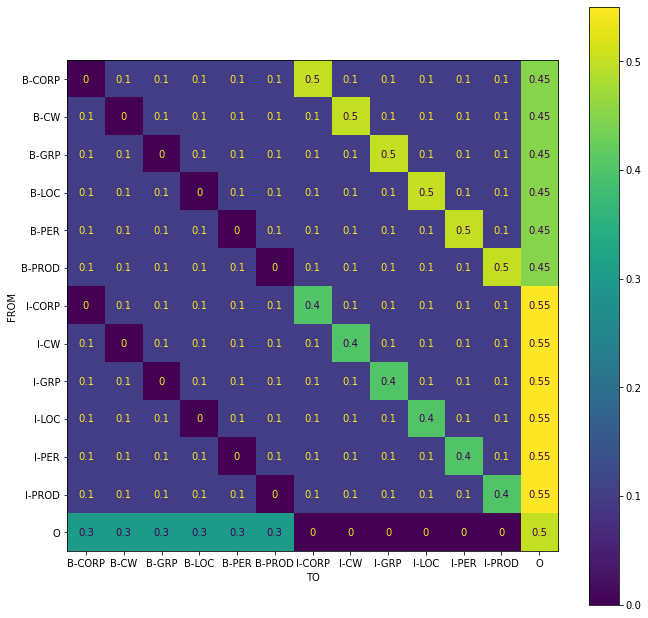

In [173]:
from sklearn.metrics import ConfusionMatrixDisplay

if student.model.crf is not None:
    mtrx = student.model.crf.trans_matrix.cpu().detach().numpy()
    # mtrx = np.exp(mtrx)
    cmdx = ConfusionMatrixDisplay(mtrx, display_labels=dataset_train.id2label)
    figx, axx = plt.subplots(figsize=(11,11))
    cmdx.plot(ax=axx)
    cmdx.ax_.set_xlabel('TO')
    cmdx.ax_.set_ylabel('FROM')

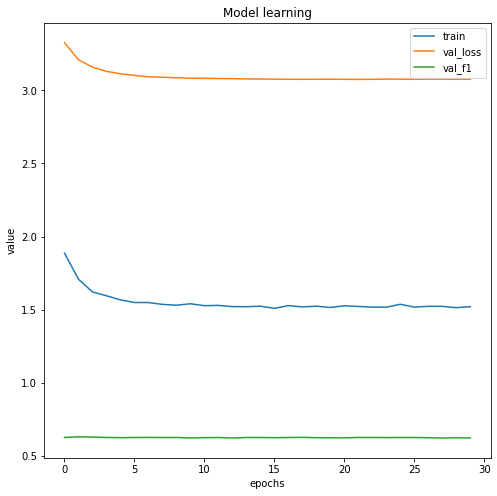

In [119]:
import matplotlib.pyplot as plt

# {'train_history':train_history, 'valid_acc_history':valid_acc_history, 'valid_f1_history':valid_f1_history}

if train_model:
    plt.figure(figsize=(8,8))
    plt.plot([i for i in range(len(history['train_history']))], history['train_history'], label='train')
    plt.plot([i for i in range(len(history['valid_loss_history']))], history['valid_loss_history'], label='val_loss')
    plt.plot([i for i in range(len(history['valid_f1_history']))], history['valid_f1_history'], label='val_f1')
    plt.xlabel('epochs')
    plt.ylabel('value')
    plt.title('Model learning')
    plt.legend()
    plt.show()

# Evaluating with other metrics...

In [239]:
def remove_indices_from_lists(y_pred, y_true, black_list):
    '''
    Removes from y_pred and y_true the values contained in black_list that matches with y_true
    '''
    y_pred_refined, y_true_refined = [], []
    for p,l in zip(y_pred, y_true):
        if l not in black_list:
            y_pred_refined.append(p) 
            y_true_refined.append(l)
    return y_pred_refined, y_true_refined

def obtain_pred_labels(model, valid_dataset, device):
    model.to(device)
    model.eval() # dropout to 0

    y_true_total = []
    y_pred_total = []
    
    with torch.no_grad():
        for sample in valid_dataset:
            inputs = sample['inputs'].to(device)
            y_true = sample['outputs']

            y_pred = model( inputs, mask = ~y_true.eq(-1) )
            if model.crf is None:
                y_pred = model.get_indices(y_pred)
                y_pred = y_pred.view(-1)
                y_true = y_true.view(-1)
            else:
                y_pred = torch.tensor([val for row in y_pred for val in row])
                y_true = torch.tensor([val for row in y_true for val in row if val != -1])

            y_pred_total.append(y_pred)
            y_true_total.append(y_true)

    y_pred, y_true = torch.cat(y_pred_total, dim=0).cpu().numpy(), torch.cat(y_true_total, dim=0).cpu().numpy()
    assert len(y_pred) == len(y_true)
    y_pred, y_true = remove_indices_from_lists(y_pred, y_true, [-1])
    return y_pred, y_true

In [240]:
y_pred, y_true = obtain_pred_labels(student.model, dataloader_dev, device)

In [241]:
from sklearn.metrics import classification_report

print( classification_report(y_true, y_pred, target_names=dataset_train.id2label) )

              precision    recall  f1-score   support

      B-CORP       0.76      0.60      0.67       136
        B-CW       0.49      0.47      0.48       173
       B-GRP       0.77      0.70      0.74       193
       B-LOC       0.84      0.83      0.83       252
       B-PER       0.89      0.86      0.87       315
      B-PROD       0.58      0.45      0.51       157
      I-CORP       0.74      0.60      0.67       121
        I-CW       0.63      0.65      0.64       271
       I-GRP       0.86      0.74      0.80       397
       I-LOC       0.77      0.77      0.77       159
       I-PER       0.88      0.88      0.88       349
      I-PROD       0.58      0.57      0.57        91
           O       0.96      0.98      0.97     11013

    accuracy                           0.93     13627
   macro avg       0.75      0.70      0.72     13627
weighted avg       0.92      0.93      0.92     13627



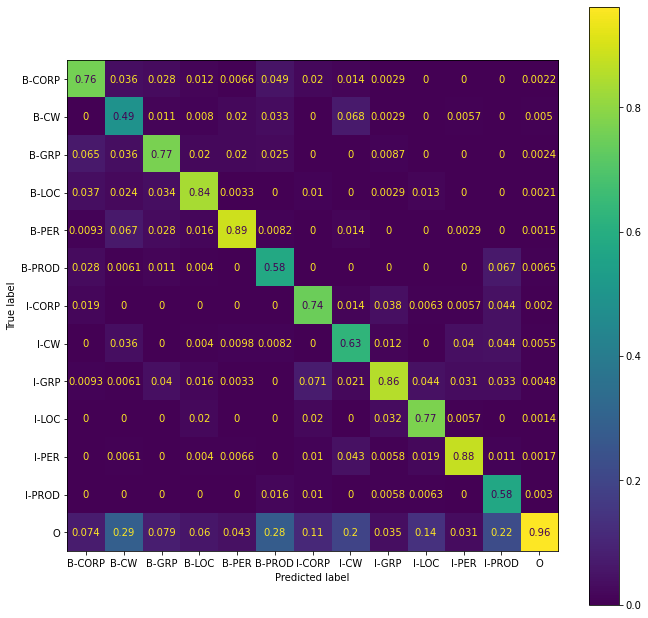

In [230]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

cm = confusion_matrix(y_true, y_pred, normalize='pred') # normalized over predicted label: the sum of each column is 1
cmd = ConfusionMatrixDisplay(cm, display_labels=dataset_train.id2label)
fig, ax = plt.subplots(figsize=(11,11))
cmd.plot(ax=ax)

In [214]:
data_eval_input = []
data_eval_label = []
for sentence in NERDataset.read_dataset(data_dev_path):
    data_eval_input.append(sentence['inputs'])
    data_eval_label.append(sentence['outputs'])

data_eval_predict = student.predict(data_eval_input)

from seqeval.metrics import accuracy_score, f1_score

acc = accuracy_score(data_eval_label, data_eval_predict)
f = f1_score(data_eval_label, data_eval_predict, average="macro")

print(f"# accuracy: {acc:.4f}")
print(f"# f1: {f:.4f}")

# accuracy: 0.9258
# f1: 0.6140


# Testing usability...

In [210]:
y_true_sample = ['B-PER','I-PER','O','B-CORP','O','O','O','O','B-LOC','I-LOC','O']
input_sample = ['John','Lucas','joined','Aiimi','as','data','scientist','in','New','York','.']

print( student.predict([input_sample]) )

[['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-PER', 'I-PER', 'O']]


Testing a long phrase...

In [209]:
long_sample = [ 'childhood', 'friends', 'Bill', 'Gates', 'and', 'Paul', 'Allen', 'sought', 'to', 'make', 'a', 'business', 'using', 'their', 'skills', 'in', 'computer', 
                'programming.', 'in', '1972,', 'they', 'founded', 'traf-o-data,', 'which', 'sold', 'a', 'rudimentary', 'computer', 'to', 'track', 'and', 'analyze', 
                'automobile', 'traffic', 'data', '.', 'gates', 'enrolled', 'at', 'harvard', 'university', 'while', 'allen', 'pursued', 'a', 'degree', 'in', 'computer', 
                'science', 'at', 'washington', 'state', 'university', ',', 'though', 'he', 'later', 'dropped', 'out', 'to', 'work', 'at', 'honeywell', '.', 'the', 'january', 
                '1975', 'issue', 'of', 'popular', 'electronics', 'featured', 'micro', 'instrumentation', 'and', 'telemetry', "systems", '(', 'mits', ')', 'altair', '8800', 'microcomputer']
long_sample_predictions = student.predict([long_sample])
print(len(long_sample), len(long_sample_predictions[0]))
print(list(zip(long_sample,long_sample_predictions[0])))

83 83
[('childhood', 'O'), ('friends', 'O'), ('Bill', 'B-PER'), ('Gates', 'I-PER'), ('and', 'O'), ('Paul', 'B-PER'), ('Allen', 'I-PER'), ('sought', 'O'), ('to', 'O'), ('make', 'O'), ('a', 'O'), ('business', 'O'), ('using', 'O'), ('their', 'O'), ('skills', 'O'), ('in', 'O'), ('computer', 'O'), ('programming.', 'O'), ('in', 'O'), ('1972,', 'B-CORP'), ('they', 'O'), ('founded', 'O'), ('traf-o-data,', 'B-CORP'), ('which', 'O'), ('sold', 'O'), ('a', 'O'), ('rudimentary', 'O'), ('computer', 'O'), ('to', 'O'), ('track', 'O'), ('and', 'O'), ('analyze', 'O'), ('automobile', 'O'), ('traffic', 'O'), ('data', 'O'), ('.', 'O'), ('gates', 'O'), ('enrolled', 'O'), ('at', 'O'), ('harvard', 'B-GRP'), ('university', 'I-GRP'), ('while', 'O'), ('allen', 'O'), ('pursued', 'O'), ('a', 'O'), ('degree', 'O'), ('in', 'O'), ('computer', 'O'), ('science', 'O'), ('at', 'O'), ('washington', 'B-GRP'), ('state', 'I-GRP'), ('university', 'I-GRP'), (',', 'O'), ('though', 'O'), ('he', 'O'), ('later', 'O'), ('dropped', 

In [45]:
from FinalModel import FinalModel
student = FinalModel(
    models_saves_path,
    'nernet_weights_nocrf.pth',
    loss_fn = loss_function
)

Creating final model...
Creating model...
Loading model weights...
Init done


In [46]:
data_eval_input = []
data_eval_label = []
for sentence in NERDataset.read_dataset(data_dev_path):
    data_eval_input.append(sentence['inputs'])
    data_eval_label.append(sentence['outputs'])

data_eval_predict = student.predict(data_eval_input)

from seqeval.metrics import accuracy_score, f1_score

acc = accuracy_score(data_eval_label, data_eval_predict)
f = f1_score(data_eval_label, data_eval_predict, average="macro")

print(f"# accuracy: {acc:.4f}")
print(f"# f1: {f:.4f}")

# accuracy: 0.9244
# f1: 0.5836


In [59]:
input_sample  = [ 'childhood', 'friends', 'Bill', 'Gates', 'and', 'Paul', 'Allen', 'sought', 'to', 'make', 'a', 'business', 'using', 'their', 'skills', 'in', 'computer', 
                'programming.', 'in', '1972,', 'they', 'founded', 'traf-o-data,', 'which', 'sold', 'a', 'rudimentary', 'computer', 'to', 'track', 'and', 'analyze', 
                'automobile', 'traffic', 'data', '.', 'gates', 'enrolled', 'at', 'harvard', 'university', 'while', 'allen', 'pursued', 'a', 'degree', 'in', 'computer', 
                'science', 'at', 'washington', 'state', 'university', ',', 'though', 'he', 'later', 'dropped', 'out', 'to', 'work', 'at', 'honeywell', '.', 'the', 'january', 
                '1975', 'issue', 'of', 'popular', 'electronics', 'featured', 'micro', 'instrumentation', 'and', 'telemetry', "systems", '(', 'mits', ')', 'altair', '8800', 'microcomputer']


print( student.predict([input_sample]) )

[['O', 'O', 'B-PER', 'I-PER', 'O', 'B-PER', 'I-PER', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-CORP', 'O', 'O', 'B-CORP', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-GRP', 'I-GRP', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-GRP', 'I-GRP', 'I-GRP', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-CORP', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-PROD', 'I-PROD', 'I-PROD']]


In [60]:
from NERDataset import NERDataset
e_input = NERDataset.encode_sentence_words(input_sample, student.vocabulary, student.globalParams['UNK_TOKEN'])
student.model.eval()
with torch.no_grad():
    print( student.model.get_indices( student.model( torch.tensor([e_input]).to(device) ) ) )

tensor([[12, 12,  4, 10, 12,  4, 10, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
         12, 12, 12, 12,  0, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
         12, 12, 12,  2,  8, 12, 12, 12, 12, 12, 12, 12, 12, 12,  2,  8,  8, 12,
         12, 12, 12, 12, 12, 12, 12, 12,  0, 12, 12, 12, 12, 12, 12, 12, 12, 12,
         12, 12, 12, 12, 12, 12, 12, 12, 12, 11, 12]], device='cuda:0')
